### Imports (shout out to iRyanBell, his imports fixed an issue with the default imports)

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, Flatten
from tensorflow.keras.layers import Activation, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


### Vanilla GAN, so much to learn here...

In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

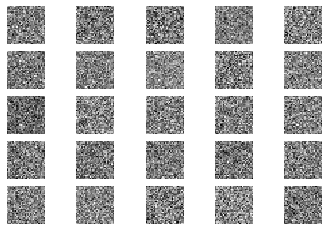

1 [D loss: 0.389745, acc.: 82.81%] [G loss: 0.637647]
2 [D loss: 0.338486, acc.: 89.06%] [G loss: 0.685668]
3 [D loss: 0.328317, acc.: 92.19%] [G loss: 0.675887]
4 [D loss: 0.305670, acc.: 92.19%] [G loss: 0.808037]
5 [D loss: 0.288947, acc.: 96.88%] [G loss: 0.943885]
6 [D loss: 0.266758, acc.: 93.75%] [G loss: 1.130128]
7 [D loss: 0.207311, acc.: 100.00%] [G loss: 1.260057]
8 [D loss: 0.189552, acc.: 100.00%] [G loss: 1.455661]
9 [D loss: 0.163681, acc.: 100.00%] [G loss: 1.677696]
10 [D loss: 0.128979, acc.: 100.00%] [G loss: 1.828202]
11 [D loss: 0.132605, acc.: 98.44%] [G loss: 1.922035]
12 [D loss: 0.116232, acc.: 100.00%] [G loss: 1.998682]
13 [D loss: 0.093071, acc.: 100.00%] [G loss: 2.203384]
14 [D loss: 0.092775, acc.: 98.44%] [G loss: 2.356096]
15 [D loss: 0.070441, acc.: 100.00%] [G loss: 2.497227]
16 [D loss: 0.056101, acc.: 100.00%] [G loss: 2.441382]
17 [D loss: 0.055906, acc.: 100.00%] [G loss: 2.582000]
18 [D loss: 0.055590, acc.: 100.00%] [G loss: 2.633989]
19 [D los

148 [D loss: 0.090878, acc.: 98.44%] [G loss: 3.807847]
149 [D loss: 0.164046, acc.: 95.31%] [G loss: 3.481708]
150 [D loss: 0.087675, acc.: 96.88%] [G loss: 3.517451]
151 [D loss: 0.133069, acc.: 95.31%] [G loss: 3.611164]
152 [D loss: 0.116482, acc.: 96.88%] [G loss: 4.084546]
153 [D loss: 0.232402, acc.: 92.19%] [G loss: 3.807210]
154 [D loss: 0.317517, acc.: 87.50%] [G loss: 3.148571]
155 [D loss: 0.142462, acc.: 95.31%] [G loss: 4.058007]
156 [D loss: 0.265987, acc.: 89.06%] [G loss: 3.748652]
157 [D loss: 0.178475, acc.: 93.75%] [G loss: 3.846521]
158 [D loss: 0.125352, acc.: 96.88%] [G loss: 3.957604]
159 [D loss: 0.170279, acc.: 98.44%] [G loss: 2.763636]
160 [D loss: 0.139348, acc.: 93.75%] [G loss: 3.530295]
161 [D loss: 0.081393, acc.: 96.88%] [G loss: 3.823537]
162 [D loss: 0.170043, acc.: 95.31%] [G loss: 3.828449]
163 [D loss: 0.140221, acc.: 95.31%] [G loss: 3.212294]
164 [D loss: 0.269554, acc.: 84.38%] [G loss: 3.350398]
165 [D loss: 0.075703, acc.: 98.44%] [G loss: 4.

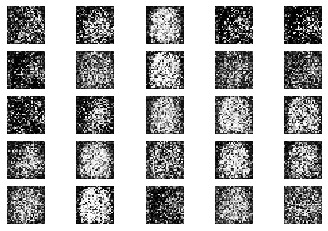

201 [D loss: 1.019041, acc.: 51.56%] [G loss: 2.310484]
202 [D loss: 0.303369, acc.: 85.94%] [G loss: 3.441959]
203 [D loss: 0.301776, acc.: 85.94%] [G loss: 2.559464]
204 [D loss: 0.240304, acc.: 90.62%] [G loss: 2.137564]
205 [D loss: 0.365665, acc.: 84.38%] [G loss: 2.554771]
206 [D loss: 0.240681, acc.: 96.88%] [G loss: 2.827060]
207 [D loss: 0.379164, acc.: 84.38%] [G loss: 2.938702]
208 [D loss: 0.409759, acc.: 81.25%] [G loss: 2.463980]
209 [D loss: 0.293449, acc.: 89.06%] [G loss: 2.602291]
210 [D loss: 0.714281, acc.: 71.88%] [G loss: 2.284140]
211 [D loss: 0.643562, acc.: 73.44%] [G loss: 2.444912]
212 [D loss: 0.621720, acc.: 75.00%] [G loss: 2.313521]
213 [D loss: 0.610465, acc.: 67.19%] [G loss: 2.753198]
214 [D loss: 0.544189, acc.: 79.69%] [G loss: 2.600714]
215 [D loss: 0.223341, acc.: 92.19%] [G loss: 2.957315]
216 [D loss: 0.585148, acc.: 75.00%] [G loss: 2.672164]
217 [D loss: 0.404221, acc.: 81.25%] [G loss: 2.488033]
218 [D loss: 0.326755, acc.: 93.75%] [G loss: 2.

349 [D loss: 0.547215, acc.: 76.56%] [G loss: 1.123344]
350 [D loss: 0.566167, acc.: 70.31%] [G loss: 1.088385]
351 [D loss: 0.633407, acc.: 57.81%] [G loss: 1.072119]
352 [D loss: 0.606526, acc.: 71.88%] [G loss: 1.030001]
353 [D loss: 0.673560, acc.: 59.38%] [G loss: 1.018488]
354 [D loss: 0.698019, acc.: 48.44%] [G loss: 0.937222]
355 [D loss: 0.637930, acc.: 64.06%] [G loss: 1.079540]
356 [D loss: 0.587510, acc.: 75.00%] [G loss: 1.116032]
357 [D loss: 0.645959, acc.: 62.50%] [G loss: 0.988661]
358 [D loss: 0.589777, acc.: 68.75%] [G loss: 1.022470]
359 [D loss: 0.691861, acc.: 65.62%] [G loss: 1.002142]
360 [D loss: 0.648256, acc.: 60.94%] [G loss: 1.100178]
361 [D loss: 0.623278, acc.: 70.31%] [G loss: 1.057472]
362 [D loss: 0.653466, acc.: 57.81%] [G loss: 0.979376]
363 [D loss: 0.591398, acc.: 73.44%] [G loss: 1.048818]
364 [D loss: 0.581209, acc.: 75.00%] [G loss: 1.040396]
365 [D loss: 0.632840, acc.: 76.56%] [G loss: 1.054363]
366 [D loss: 0.642233, acc.: 68.75%] [G loss: 1.

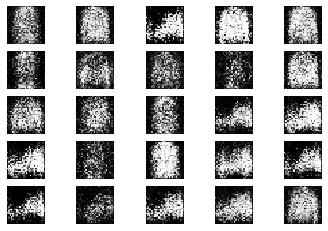

401 [D loss: 0.653790, acc.: 65.62%] [G loss: 0.863918]
402 [D loss: 0.531908, acc.: 79.69%] [G loss: 0.982397]
403 [D loss: 0.586151, acc.: 75.00%] [G loss: 0.982867]
404 [D loss: 0.635223, acc.: 67.19%] [G loss: 1.002664]
405 [D loss: 0.605302, acc.: 73.44%] [G loss: 1.027939]
406 [D loss: 0.584713, acc.: 76.56%] [G loss: 1.061435]
407 [D loss: 0.594083, acc.: 70.31%] [G loss: 1.091590]
408 [D loss: 0.609562, acc.: 64.06%] [G loss: 1.050937]
409 [D loss: 0.595159, acc.: 67.19%] [G loss: 1.014424]
410 [D loss: 0.604226, acc.: 65.62%] [G loss: 1.006899]
411 [D loss: 0.660623, acc.: 57.81%] [G loss: 1.000276]
412 [D loss: 0.662829, acc.: 59.38%] [G loss: 0.863802]
413 [D loss: 0.695649, acc.: 62.50%] [G loss: 0.892802]
414 [D loss: 0.643057, acc.: 60.94%] [G loss: 0.892909]
415 [D loss: 0.681556, acc.: 56.25%] [G loss: 0.964847]
416 [D loss: 0.608402, acc.: 73.44%] [G loss: 0.969000]
417 [D loss: 0.661424, acc.: 54.69%] [G loss: 0.912693]
418 [D loss: 0.661736, acc.: 62.50%] [G loss: 0.

548 [D loss: 0.633489, acc.: 64.06%] [G loss: 0.986478]
549 [D loss: 0.586597, acc.: 64.06%] [G loss: 1.051988]
550 [D loss: 0.583744, acc.: 71.88%] [G loss: 0.943891]
551 [D loss: 0.569453, acc.: 71.88%] [G loss: 0.880152]
552 [D loss: 0.631533, acc.: 60.94%] [G loss: 0.919639]
553 [D loss: 0.670969, acc.: 56.25%] [G loss: 1.036358]
554 [D loss: 0.603854, acc.: 65.62%] [G loss: 0.945555]
555 [D loss: 0.591078, acc.: 71.88%] [G loss: 0.959397]
556 [D loss: 0.581057, acc.: 73.44%] [G loss: 1.053904]
557 [D loss: 0.653692, acc.: 64.06%] [G loss: 1.026917]
558 [D loss: 0.686585, acc.: 51.56%] [G loss: 0.943913]
559 [D loss: 0.647913, acc.: 56.25%] [G loss: 0.980940]
560 [D loss: 0.572289, acc.: 75.00%] [G loss: 0.998081]
561 [D loss: 0.668363, acc.: 48.44%] [G loss: 0.927573]
562 [D loss: 0.661755, acc.: 60.94%] [G loss: 0.858949]
563 [D loss: 0.701431, acc.: 57.81%] [G loss: 0.933192]
564 [D loss: 0.636277, acc.: 64.06%] [G loss: 0.979036]
565 [D loss: 0.562350, acc.: 67.19%] [G loss: 1.

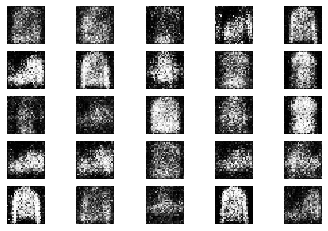

601 [D loss: 0.602822, acc.: 68.75%] [G loss: 0.845717]
602 [D loss: 0.667755, acc.: 60.94%] [G loss: 0.779985]
603 [D loss: 0.612864, acc.: 62.50%] [G loss: 0.873997]
604 [D loss: 0.608503, acc.: 64.06%] [G loss: 0.827709]
605 [D loss: 0.674037, acc.: 62.50%] [G loss: 0.848601]
606 [D loss: 0.649360, acc.: 65.62%] [G loss: 0.797756]
607 [D loss: 0.546993, acc.: 73.44%] [G loss: 0.865497]
608 [D loss: 0.649247, acc.: 60.94%] [G loss: 0.960695]
609 [D loss: 0.662201, acc.: 60.94%] [G loss: 1.009487]
610 [D loss: 0.602854, acc.: 70.31%] [G loss: 0.954473]
611 [D loss: 0.609965, acc.: 70.31%] [G loss: 0.852343]
612 [D loss: 0.586717, acc.: 67.19%] [G loss: 0.797535]
613 [D loss: 0.617070, acc.: 65.62%] [G loss: 0.921789]
614 [D loss: 0.616588, acc.: 64.06%] [G loss: 0.941884]
615 [D loss: 0.696921, acc.: 59.38%] [G loss: 0.842351]
616 [D loss: 0.646846, acc.: 57.81%] [G loss: 0.904220]
617 [D loss: 0.637282, acc.: 70.31%] [G loss: 0.884809]
618 [D loss: 0.590690, acc.: 71.88%] [G loss: 0.

748 [D loss: 0.665562, acc.: 56.25%] [G loss: 0.838995]
749 [D loss: 0.607941, acc.: 60.94%] [G loss: 0.861288]
750 [D loss: 0.701475, acc.: 57.81%] [G loss: 0.849616]
751 [D loss: 0.661158, acc.: 65.62%] [G loss: 0.856721]
752 [D loss: 0.637901, acc.: 57.81%] [G loss: 0.892888]
753 [D loss: 0.695215, acc.: 53.12%] [G loss: 0.878587]
754 [D loss: 0.608516, acc.: 68.75%] [G loss: 0.877454]
755 [D loss: 0.587834, acc.: 68.75%] [G loss: 0.975476]
756 [D loss: 0.588656, acc.: 73.44%] [G loss: 0.991961]
757 [D loss: 0.636974, acc.: 68.75%] [G loss: 0.890164]
758 [D loss: 0.595136, acc.: 62.50%] [G loss: 0.916345]
759 [D loss: 0.632161, acc.: 65.62%] [G loss: 0.902469]
760 [D loss: 0.570471, acc.: 71.88%] [G loss: 1.037046]
761 [D loss: 0.622646, acc.: 62.50%] [G loss: 0.930075]
762 [D loss: 0.677831, acc.: 60.94%] [G loss: 0.947049]
763 [D loss: 0.677475, acc.: 53.12%] [G loss: 0.872219]
764 [D loss: 0.634464, acc.: 62.50%] [G loss: 0.929066]
765 [D loss: 0.604143, acc.: 70.31%] [G loss: 0.

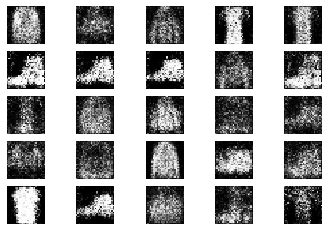

801 [D loss: 0.653767, acc.: 54.69%] [G loss: 0.903114]
802 [D loss: 0.544256, acc.: 75.00%] [G loss: 0.920249]
803 [D loss: 0.670357, acc.: 60.94%] [G loss: 0.877265]
804 [D loss: 0.605548, acc.: 62.50%] [G loss: 0.951552]
805 [D loss: 0.614931, acc.: 64.06%] [G loss: 0.904602]
806 [D loss: 0.711257, acc.: 48.44%] [G loss: 0.878145]
807 [D loss: 0.623654, acc.: 75.00%] [G loss: 0.939613]
808 [D loss: 0.640436, acc.: 60.94%] [G loss: 0.924303]
809 [D loss: 0.609476, acc.: 64.06%] [G loss: 0.949469]
810 [D loss: 0.612412, acc.: 67.19%] [G loss: 0.944862]
811 [D loss: 0.607557, acc.: 71.88%] [G loss: 0.891474]
812 [D loss: 0.630069, acc.: 68.75%] [G loss: 0.870372]
813 [D loss: 0.632912, acc.: 67.19%] [G loss: 0.821468]
814 [D loss: 0.655297, acc.: 56.25%] [G loss: 0.841640]
815 [D loss: 0.606368, acc.: 65.62%] [G loss: 0.852671]
816 [D loss: 0.675730, acc.: 60.94%] [G loss: 0.944291]
817 [D loss: 0.640119, acc.: 60.94%] [G loss: 0.955477]
818 [D loss: 0.647042, acc.: 62.50%] [G loss: 0.

949 [D loss: 0.689402, acc.: 60.94%] [G loss: 0.889720]
950 [D loss: 0.692278, acc.: 46.88%] [G loss: 0.943401]
951 [D loss: 0.615898, acc.: 71.88%] [G loss: 0.863532]
952 [D loss: 0.676972, acc.: 60.94%] [G loss: 0.904199]
953 [D loss: 0.640250, acc.: 60.94%] [G loss: 0.841650]
954 [D loss: 0.667810, acc.: 56.25%] [G loss: 0.898039]
955 [D loss: 0.645749, acc.: 60.94%] [G loss: 0.834212]
956 [D loss: 0.626228, acc.: 59.38%] [G loss: 0.896831]
957 [D loss: 0.682660, acc.: 60.94%] [G loss: 0.788772]
958 [D loss: 0.646282, acc.: 65.62%] [G loss: 0.862557]
959 [D loss: 0.623411, acc.: 65.62%] [G loss: 0.820561]
960 [D loss: 0.577634, acc.: 70.31%] [G loss: 0.965518]
961 [D loss: 0.615329, acc.: 68.75%] [G loss: 0.956879]
962 [D loss: 0.683491, acc.: 57.81%] [G loss: 0.785131]
963 [D loss: 0.687677, acc.: 56.25%] [G loss: 0.749437]
964 [D loss: 0.655689, acc.: 64.06%] [G loss: 0.816660]
965 [D loss: 0.587258, acc.: 71.88%] [G loss: 0.842563]
966 [D loss: 0.549886, acc.: 75.00%] [G loss: 0.

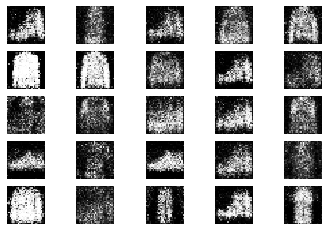

1001 [D loss: 0.695033, acc.: 56.25%] [G loss: 0.788429]
1002 [D loss: 0.664344, acc.: 56.25%] [G loss: 0.781189]
1003 [D loss: 0.647531, acc.: 62.50%] [G loss: 0.777379]
1004 [D loss: 0.602107, acc.: 65.62%] [G loss: 0.831192]
1005 [D loss: 0.612544, acc.: 67.19%] [G loss: 0.864432]
1006 [D loss: 0.643761, acc.: 68.75%] [G loss: 0.866031]
1007 [D loss: 0.711226, acc.: 62.50%] [G loss: 0.904382]
1008 [D loss: 0.614714, acc.: 64.06%] [G loss: 0.828222]
1009 [D loss: 0.616667, acc.: 68.75%] [G loss: 0.915578]
1010 [D loss: 0.628592, acc.: 65.62%] [G loss: 0.888866]
1011 [D loss: 0.675340, acc.: 59.38%] [G loss: 0.878630]
1012 [D loss: 0.651578, acc.: 68.75%] [G loss: 0.853224]
1013 [D loss: 0.695990, acc.: 51.56%] [G loss: 0.870076]
1014 [D loss: 0.671453, acc.: 62.50%] [G loss: 0.852209]
1015 [D loss: 0.643527, acc.: 59.38%] [G loss: 0.778506]
1016 [D loss: 0.651757, acc.: 65.62%] [G loss: 0.826708]
1017 [D loss: 0.619254, acc.: 59.38%] [G loss: 0.834579]
1018 [D loss: 0.626197, acc.: 6

1145 [D loss: 0.678900, acc.: 56.25%] [G loss: 0.796607]
1146 [D loss: 0.698408, acc.: 53.12%] [G loss: 0.822495]
1147 [D loss: 0.643214, acc.: 62.50%] [G loss: 0.907253]
1148 [D loss: 0.667136, acc.: 51.56%] [G loss: 0.878893]
1149 [D loss: 0.642806, acc.: 60.94%] [G loss: 0.953896]
1150 [D loss: 0.616860, acc.: 68.75%] [G loss: 0.880519]
1151 [D loss: 0.694031, acc.: 51.56%] [G loss: 0.813544]
1152 [D loss: 0.615228, acc.: 64.06%] [G loss: 0.797440]
1153 [D loss: 0.683136, acc.: 50.00%] [G loss: 0.841211]
1154 [D loss: 0.650789, acc.: 53.12%] [G loss: 0.773185]
1155 [D loss: 0.647262, acc.: 60.94%] [G loss: 0.807973]
1156 [D loss: 0.642362, acc.: 62.50%] [G loss: 0.820057]
1157 [D loss: 0.647445, acc.: 57.81%] [G loss: 0.795581]
1158 [D loss: 0.577696, acc.: 71.88%] [G loss: 0.831512]
1159 [D loss: 0.638600, acc.: 60.94%] [G loss: 0.827733]
1160 [D loss: 0.618113, acc.: 68.75%] [G loss: 0.837569]
1161 [D loss: 0.628845, acc.: 70.31%] [G loss: 0.860396]
1162 [D loss: 0.634360, acc.: 6

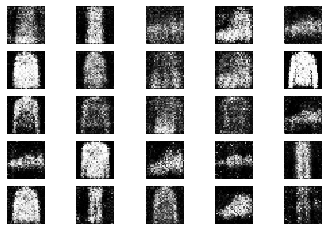

1201 [D loss: 0.643889, acc.: 57.81%] [G loss: 0.848584]
1202 [D loss: 0.614209, acc.: 60.94%] [G loss: 0.838011]
1203 [D loss: 0.654074, acc.: 51.56%] [G loss: 0.842572]
1204 [D loss: 0.618847, acc.: 59.38%] [G loss: 0.874035]
1205 [D loss: 0.609475, acc.: 71.88%] [G loss: 0.853348]
1206 [D loss: 0.630280, acc.: 62.50%] [G loss: 0.908946]
1207 [D loss: 0.690921, acc.: 54.69%] [G loss: 0.812332]
1208 [D loss: 0.630517, acc.: 59.38%] [G loss: 0.785461]
1209 [D loss: 0.654552, acc.: 59.38%] [G loss: 0.776172]
1210 [D loss: 0.657587, acc.: 53.12%] [G loss: 0.766821]
1211 [D loss: 0.681462, acc.: 50.00%] [G loss: 0.833934]
1212 [D loss: 0.652642, acc.: 60.94%] [G loss: 0.789352]
1213 [D loss: 0.634256, acc.: 65.62%] [G loss: 0.868013]
1214 [D loss: 0.601548, acc.: 73.44%] [G loss: 0.764872]
1215 [D loss: 0.679982, acc.: 60.94%] [G loss: 0.790190]
1216 [D loss: 0.608620, acc.: 68.75%] [G loss: 0.826317]
1217 [D loss: 0.634716, acc.: 64.06%] [G loss: 0.834486]
1218 [D loss: 0.631320, acc.: 6

1345 [D loss: 0.675069, acc.: 54.69%] [G loss: 0.906554]
1346 [D loss: 0.639210, acc.: 60.94%] [G loss: 0.896374]
1347 [D loss: 0.608960, acc.: 75.00%] [G loss: 0.874621]
1348 [D loss: 0.639646, acc.: 67.19%] [G loss: 0.810154]
1349 [D loss: 0.659530, acc.: 51.56%] [G loss: 0.809919]
1350 [D loss: 0.628558, acc.: 67.19%] [G loss: 0.919821]
1351 [D loss: 0.698150, acc.: 57.81%] [G loss: 0.823955]
1352 [D loss: 0.681700, acc.: 51.56%] [G loss: 0.802612]
1353 [D loss: 0.590375, acc.: 65.62%] [G loss: 0.796683]
1354 [D loss: 0.649859, acc.: 59.38%] [G loss: 0.747665]
1355 [D loss: 0.642640, acc.: 64.06%] [G loss: 0.847303]
1356 [D loss: 0.626532, acc.: 67.19%] [G loss: 0.765525]
1357 [D loss: 0.603410, acc.: 68.75%] [G loss: 0.795308]
1358 [D loss: 0.656093, acc.: 62.50%] [G loss: 0.909536]
1359 [D loss: 0.674354, acc.: 62.50%] [G loss: 0.717701]
1360 [D loss: 0.631344, acc.: 60.94%] [G loss: 0.770988]
1361 [D loss: 0.623367, acc.: 67.19%] [G loss: 0.895228]
1362 [D loss: 0.626064, acc.: 7

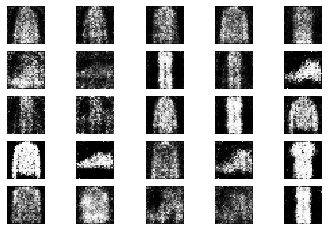

1401 [D loss: 0.637721, acc.: 59.38%] [G loss: 0.923245]
1402 [D loss: 0.649422, acc.: 57.81%] [G loss: 0.817497]
1403 [D loss: 0.718349, acc.: 48.44%] [G loss: 0.815463]
1404 [D loss: 0.654251, acc.: 57.81%] [G loss: 0.840485]
1405 [D loss: 0.611569, acc.: 64.06%] [G loss: 0.872907]
1406 [D loss: 0.629145, acc.: 68.75%] [G loss: 0.825128]
1407 [D loss: 0.577311, acc.: 73.44%] [G loss: 0.884113]
1408 [D loss: 0.684878, acc.: 53.12%] [G loss: 0.776039]
1409 [D loss: 0.634355, acc.: 59.38%] [G loss: 0.785880]
1410 [D loss: 0.621765, acc.: 60.94%] [G loss: 0.821679]
1411 [D loss: 0.583612, acc.: 71.88%] [G loss: 0.769157]
1412 [D loss: 0.639374, acc.: 56.25%] [G loss: 0.846522]
1413 [D loss: 0.618285, acc.: 68.75%] [G loss: 0.868856]
1414 [D loss: 0.665998, acc.: 51.56%] [G loss: 0.797267]
1415 [D loss: 0.667062, acc.: 65.62%] [G loss: 0.875646]
1416 [D loss: 0.627410, acc.: 68.75%] [G loss: 0.944121]
1417 [D loss: 0.709288, acc.: 51.56%] [G loss: 0.864342]
1418 [D loss: 0.670832, acc.: 5

1545 [D loss: 0.620898, acc.: 65.62%] [G loss: 0.857101]
1546 [D loss: 0.598590, acc.: 73.44%] [G loss: 0.906379]
1547 [D loss: 0.587011, acc.: 68.75%] [G loss: 0.957304]
1548 [D loss: 0.602664, acc.: 70.31%] [G loss: 0.892509]
1549 [D loss: 0.651318, acc.: 64.06%] [G loss: 0.858239]
1550 [D loss: 0.632448, acc.: 67.19%] [G loss: 0.876543]
1551 [D loss: 0.624616, acc.: 67.19%] [G loss: 0.868547]
1552 [D loss: 0.608863, acc.: 65.62%] [G loss: 0.891183]
1553 [D loss: 0.570557, acc.: 75.00%] [G loss: 0.862610]
1554 [D loss: 0.698598, acc.: 54.69%] [G loss: 0.858444]
1555 [D loss: 0.619793, acc.: 68.75%] [G loss: 0.835212]
1556 [D loss: 0.612954, acc.: 73.44%] [G loss: 0.899809]
1557 [D loss: 0.701736, acc.: 50.00%] [G loss: 0.856175]
1558 [D loss: 0.655371, acc.: 59.38%] [G loss: 0.873142]
1559 [D loss: 0.622812, acc.: 64.06%] [G loss: 0.913194]
1560 [D loss: 0.653757, acc.: 67.19%] [G loss: 0.948271]
1561 [D loss: 0.633078, acc.: 68.75%] [G loss: 0.864483]
1562 [D loss: 0.638176, acc.: 6

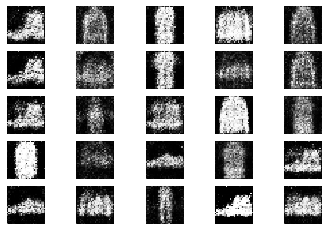

1601 [D loss: 0.637920, acc.: 60.94%] [G loss: 0.924482]
1602 [D loss: 0.649793, acc.: 56.25%] [G loss: 0.914211]
1603 [D loss: 0.658775, acc.: 64.06%] [G loss: 0.877746]
1604 [D loss: 0.646965, acc.: 59.38%] [G loss: 0.960181]
1605 [D loss: 0.583740, acc.: 71.88%] [G loss: 0.798152]
1606 [D loss: 0.628135, acc.: 62.50%] [G loss: 0.879672]
1607 [D loss: 0.576191, acc.: 78.12%] [G loss: 0.841518]
1608 [D loss: 0.604910, acc.: 62.50%] [G loss: 0.885903]
1609 [D loss: 0.619827, acc.: 67.19%] [G loss: 0.843603]
1610 [D loss: 0.623001, acc.: 68.75%] [G loss: 0.822839]
1611 [D loss: 0.678659, acc.: 54.69%] [G loss: 0.749702]
1612 [D loss: 0.592448, acc.: 67.19%] [G loss: 0.865213]
1613 [D loss: 0.575633, acc.: 73.44%] [G loss: 0.880897]
1614 [D loss: 0.678354, acc.: 59.38%] [G loss: 0.846188]
1615 [D loss: 0.629650, acc.: 67.19%] [G loss: 0.840309]
1616 [D loss: 0.665795, acc.: 60.94%] [G loss: 0.832042]
1617 [D loss: 0.638855, acc.: 67.19%] [G loss: 0.845242]
1618 [D loss: 0.596576, acc.: 6

1745 [D loss: 0.661803, acc.: 57.81%] [G loss: 0.856488]
1746 [D loss: 0.634832, acc.: 64.06%] [G loss: 0.897406]
1747 [D loss: 0.602660, acc.: 67.19%] [G loss: 0.943178]
1748 [D loss: 0.629819, acc.: 70.31%] [G loss: 0.855579]
1749 [D loss: 0.626106, acc.: 65.62%] [G loss: 0.857779]
1750 [D loss: 0.654803, acc.: 51.56%] [G loss: 0.944099]
1751 [D loss: 0.612849, acc.: 62.50%] [G loss: 0.839101]
1752 [D loss: 0.585946, acc.: 65.62%] [G loss: 0.895576]
1753 [D loss: 0.636842, acc.: 75.00%] [G loss: 0.820801]
1754 [D loss: 0.651493, acc.: 62.50%] [G loss: 0.858963]
1755 [D loss: 0.662759, acc.: 57.81%] [G loss: 0.849232]
1756 [D loss: 0.660714, acc.: 54.69%] [G loss: 0.843936]
1757 [D loss: 0.639821, acc.: 60.94%] [G loss: 0.875452]
1758 [D loss: 0.576583, acc.: 73.44%] [G loss: 0.945520]
1759 [D loss: 0.604854, acc.: 68.75%] [G loss: 0.912001]
1760 [D loss: 0.609140, acc.: 68.75%] [G loss: 0.868287]
1761 [D loss: 0.619486, acc.: 65.62%] [G loss: 0.973035]
1762 [D loss: 0.593455, acc.: 7

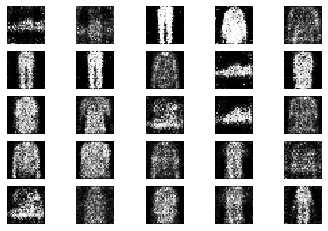

1801 [D loss: 0.656650, acc.: 60.94%] [G loss: 0.925107]
1802 [D loss: 0.567987, acc.: 70.31%] [G loss: 0.860903]
1803 [D loss: 0.594755, acc.: 68.75%] [G loss: 0.926153]
1804 [D loss: 0.602894, acc.: 68.75%] [G loss: 0.887805]
1805 [D loss: 0.646458, acc.: 64.06%] [G loss: 0.877916]
1806 [D loss: 0.634149, acc.: 62.50%] [G loss: 0.871049]
1807 [D loss: 0.658015, acc.: 60.94%] [G loss: 0.831883]
1808 [D loss: 0.670350, acc.: 60.94%] [G loss: 0.907701]
1809 [D loss: 0.603998, acc.: 67.19%] [G loss: 0.901099]
1810 [D loss: 0.625458, acc.: 65.62%] [G loss: 0.984199]
1811 [D loss: 0.564850, acc.: 67.19%] [G loss: 0.941614]
1812 [D loss: 0.603415, acc.: 70.31%] [G loss: 0.992545]
1813 [D loss: 0.725419, acc.: 51.56%] [G loss: 0.974665]
1814 [D loss: 0.590930, acc.: 70.31%] [G loss: 0.938985]
1815 [D loss: 0.570266, acc.: 71.88%] [G loss: 0.935382]
1816 [D loss: 0.675916, acc.: 54.69%] [G loss: 0.915496]
1817 [D loss: 0.726057, acc.: 48.44%] [G loss: 0.967048]
1818 [D loss: 0.598452, acc.: 7

1946 [D loss: 0.691737, acc.: 51.56%] [G loss: 0.890259]
1947 [D loss: 0.590036, acc.: 71.88%] [G loss: 0.897383]
1948 [D loss: 0.642586, acc.: 67.19%] [G loss: 0.836573]
1949 [D loss: 0.632428, acc.: 59.38%] [G loss: 0.870637]
1950 [D loss: 0.610145, acc.: 60.94%] [G loss: 0.879848]
1951 [D loss: 0.665697, acc.: 57.81%] [G loss: 0.952684]
1952 [D loss: 0.726887, acc.: 43.75%] [G loss: 0.890709]
1953 [D loss: 0.582515, acc.: 75.00%] [G loss: 0.878267]
1954 [D loss: 0.596967, acc.: 67.19%] [G loss: 0.892818]
1955 [D loss: 0.672079, acc.: 56.25%] [G loss: 0.887509]
1956 [D loss: 0.669599, acc.: 54.69%] [G loss: 0.835280]
1957 [D loss: 0.671374, acc.: 53.12%] [G loss: 0.930102]
1958 [D loss: 0.635756, acc.: 60.94%] [G loss: 0.933596]
1959 [D loss: 0.676490, acc.: 62.50%] [G loss: 0.946123]
1960 [D loss: 0.633964, acc.: 65.62%] [G loss: 0.917823]
1961 [D loss: 0.612151, acc.: 65.62%] [G loss: 0.860188]
1962 [D loss: 0.632009, acc.: 57.81%] [G loss: 0.842792]
1963 [D loss: 0.600700, acc.: 6

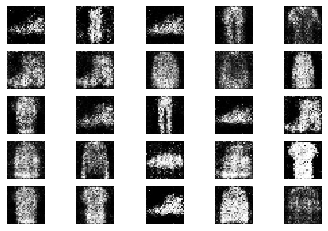

2001 [D loss: 0.685166, acc.: 56.25%] [G loss: 0.904804]
2002 [D loss: 0.609269, acc.: 67.19%] [G loss: 0.963475]
2003 [D loss: 0.674949, acc.: 54.69%] [G loss: 0.924853]
2004 [D loss: 0.639022, acc.: 62.50%] [G loss: 0.866680]
2005 [D loss: 0.560897, acc.: 73.44%] [G loss: 0.970699]
2006 [D loss: 0.691122, acc.: 50.00%] [G loss: 1.008066]
2007 [D loss: 0.670011, acc.: 68.75%] [G loss: 0.786080]
2008 [D loss: 0.714973, acc.: 46.88%] [G loss: 0.844388]
2009 [D loss: 0.593451, acc.: 68.75%] [G loss: 0.892940]
2010 [D loss: 0.651998, acc.: 59.38%] [G loss: 0.878288]
2011 [D loss: 0.625220, acc.: 62.50%] [G loss: 0.837496]
2012 [D loss: 0.632968, acc.: 65.62%] [G loss: 0.815122]
2013 [D loss: 0.569699, acc.: 79.69%] [G loss: 0.893800]
2014 [D loss: 0.630519, acc.: 65.62%] [G loss: 0.868051]
2015 [D loss: 0.685557, acc.: 59.38%] [G loss: 0.933908]
2016 [D loss: 0.638866, acc.: 62.50%] [G loss: 0.902147]
2017 [D loss: 0.625914, acc.: 71.88%] [G loss: 0.888330]
2018 [D loss: 0.638211, acc.: 6

2145 [D loss: 0.603053, acc.: 75.00%] [G loss: 0.936460]
2146 [D loss: 0.570356, acc.: 71.88%] [G loss: 0.884483]
2147 [D loss: 0.635141, acc.: 65.62%] [G loss: 0.927553]
2148 [D loss: 0.624464, acc.: 59.38%] [G loss: 0.910768]
2149 [D loss: 0.668481, acc.: 59.38%] [G loss: 0.905114]
2150 [D loss: 0.653525, acc.: 54.69%] [G loss: 0.889593]
2151 [D loss: 0.580089, acc.: 70.31%] [G loss: 0.919972]
2152 [D loss: 0.575072, acc.: 67.19%] [G loss: 0.924250]
2153 [D loss: 0.564129, acc.: 70.31%] [G loss: 0.850363]
2154 [D loss: 0.646442, acc.: 64.06%] [G loss: 0.888379]
2155 [D loss: 0.670232, acc.: 59.38%] [G loss: 0.872218]
2156 [D loss: 0.559347, acc.: 76.56%] [G loss: 0.862136]
2157 [D loss: 0.606228, acc.: 62.50%] [G loss: 0.904529]
2158 [D loss: 0.627190, acc.: 62.50%] [G loss: 0.830652]
2159 [D loss: 0.652285, acc.: 62.50%] [G loss: 0.900275]
2160 [D loss: 0.589168, acc.: 68.75%] [G loss: 0.930561]
2161 [D loss: 0.612747, acc.: 70.31%] [G loss: 0.882272]
2162 [D loss: 0.611528, acc.: 6

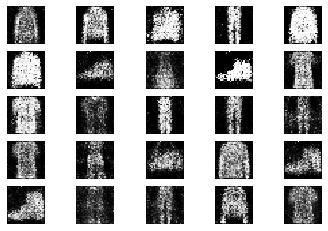

2201 [D loss: 0.616289, acc.: 68.75%] [G loss: 0.819362]
2202 [D loss: 0.611570, acc.: 62.50%] [G loss: 0.944841]
2203 [D loss: 0.585002, acc.: 70.31%] [G loss: 0.889687]
2204 [D loss: 0.608804, acc.: 59.38%] [G loss: 0.872072]
2205 [D loss: 0.602290, acc.: 67.19%] [G loss: 0.886110]
2206 [D loss: 0.551009, acc.: 70.31%] [G loss: 0.822941]
2207 [D loss: 0.604796, acc.: 65.62%] [G loss: 0.999260]
2208 [D loss: 0.744744, acc.: 50.00%] [G loss: 0.818252]
2209 [D loss: 0.660975, acc.: 60.94%] [G loss: 1.001446]
2210 [D loss: 0.712353, acc.: 64.06%] [G loss: 0.917394]
2211 [D loss: 0.662641, acc.: 59.38%] [G loss: 0.919942]
2212 [D loss: 0.611036, acc.: 68.75%] [G loss: 0.949713]
2213 [D loss: 0.645829, acc.: 62.50%] [G loss: 0.845273]
2214 [D loss: 0.550573, acc.: 78.12%] [G loss: 0.965069]
2215 [D loss: 0.688839, acc.: 51.56%] [G loss: 0.881165]
2216 [D loss: 0.644331, acc.: 65.62%] [G loss: 0.923649]
2217 [D loss: 0.646361, acc.: 59.38%] [G loss: 0.850761]
2218 [D loss: 0.609114, acc.: 7

2346 [D loss: 0.645399, acc.: 64.06%] [G loss: 0.887314]
2347 [D loss: 0.611630, acc.: 70.31%] [G loss: 0.933665]
2348 [D loss: 0.637830, acc.: 62.50%] [G loss: 0.959234]
2349 [D loss: 0.652750, acc.: 60.94%] [G loss: 0.982659]
2350 [D loss: 0.558936, acc.: 75.00%] [G loss: 0.998958]
2351 [D loss: 0.707316, acc.: 57.81%] [G loss: 0.985169]
2352 [D loss: 0.623211, acc.: 57.81%] [G loss: 0.891718]
2353 [D loss: 0.638145, acc.: 60.94%] [G loss: 0.916183]
2354 [D loss: 0.579947, acc.: 68.75%] [G loss: 0.924003]
2355 [D loss: 0.567604, acc.: 71.88%] [G loss: 0.977157]
2356 [D loss: 0.602033, acc.: 71.88%] [G loss: 0.917989]
2357 [D loss: 0.664570, acc.: 56.25%] [G loss: 0.884572]
2358 [D loss: 0.635857, acc.: 56.25%] [G loss: 0.869414]
2359 [D loss: 0.690513, acc.: 59.38%] [G loss: 0.802607]
2360 [D loss: 0.645960, acc.: 59.38%] [G loss: 0.925262]
2361 [D loss: 0.633236, acc.: 65.62%] [G loss: 0.891318]
2362 [D loss: 0.622707, acc.: 68.75%] [G loss: 0.876236]
2363 [D loss: 0.664712, acc.: 6

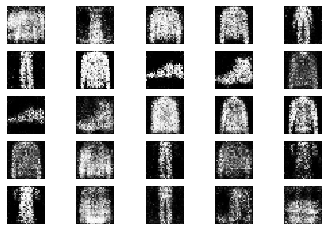

2401 [D loss: 0.658023, acc.: 60.94%] [G loss: 0.936165]
2402 [D loss: 0.646688, acc.: 67.19%] [G loss: 0.889786]
2403 [D loss: 0.603630, acc.: 68.75%] [G loss: 0.813521]
2404 [D loss: 0.692848, acc.: 56.25%] [G loss: 0.891578]
2405 [D loss: 0.628349, acc.: 57.81%] [G loss: 0.851076]
2406 [D loss: 0.652770, acc.: 54.69%] [G loss: 0.868843]
2407 [D loss: 0.670993, acc.: 54.69%] [G loss: 0.943986]
2408 [D loss: 0.592912, acc.: 71.88%] [G loss: 0.852466]
2409 [D loss: 0.618790, acc.: 70.31%] [G loss: 0.885772]
2410 [D loss: 0.620366, acc.: 68.75%] [G loss: 0.853387]
2411 [D loss: 0.612257, acc.: 65.62%] [G loss: 0.904952]
2412 [D loss: 0.660085, acc.: 56.25%] [G loss: 0.871538]
2413 [D loss: 0.611381, acc.: 70.31%] [G loss: 0.884289]
2414 [D loss: 0.630580, acc.: 67.19%] [G loss: 0.932136]
2415 [D loss: 0.672371, acc.: 65.62%] [G loss: 0.917215]
2416 [D loss: 0.644953, acc.: 60.94%] [G loss: 0.955449]
2417 [D loss: 0.659583, acc.: 60.94%] [G loss: 0.897704]
2418 [D loss: 0.648634, acc.: 6

2545 [D loss: 0.675227, acc.: 60.94%] [G loss: 0.876387]
2546 [D loss: 0.671302, acc.: 60.94%] [G loss: 1.036713]
2547 [D loss: 0.629244, acc.: 60.94%] [G loss: 0.981413]
2548 [D loss: 0.671677, acc.: 59.38%] [G loss: 0.883328]
2549 [D loss: 0.641858, acc.: 64.06%] [G loss: 0.917335]
2550 [D loss: 0.638309, acc.: 67.19%] [G loss: 0.989211]
2551 [D loss: 0.602582, acc.: 71.88%] [G loss: 0.953345]
2552 [D loss: 0.567721, acc.: 73.44%] [G loss: 0.912472]
2553 [D loss: 0.695659, acc.: 60.94%] [G loss: 0.941539]
2554 [D loss: 0.614009, acc.: 67.19%] [G loss: 0.781731]
2555 [D loss: 0.618908, acc.: 65.62%] [G loss: 0.821020]
2556 [D loss: 0.654368, acc.: 57.81%] [G loss: 0.954942]
2557 [D loss: 0.630937, acc.: 67.19%] [G loss: 0.846884]
2558 [D loss: 0.615216, acc.: 62.50%] [G loss: 0.900571]
2559 [D loss: 0.561058, acc.: 70.31%] [G loss: 0.919858]
2560 [D loss: 0.606995, acc.: 64.06%] [G loss: 0.840809]
2561 [D loss: 0.530044, acc.: 85.94%] [G loss: 0.973014]
2562 [D loss: 0.655419, acc.: 6

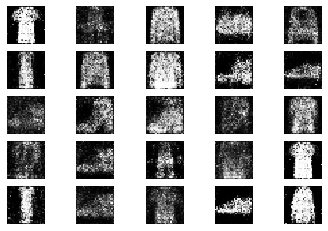

2601 [D loss: 0.636009, acc.: 62.50%] [G loss: 0.910005]
2602 [D loss: 0.593302, acc.: 78.12%] [G loss: 0.916519]
2603 [D loss: 0.680818, acc.: 56.25%] [G loss: 0.966009]
2604 [D loss: 0.567771, acc.: 73.44%] [G loss: 0.867618]
2605 [D loss: 0.668132, acc.: 54.69%] [G loss: 0.903375]
2606 [D loss: 0.597564, acc.: 73.44%] [G loss: 0.952202]
2607 [D loss: 0.595074, acc.: 68.75%] [G loss: 0.884002]
2608 [D loss: 0.589127, acc.: 68.75%] [G loss: 0.849970]
2609 [D loss: 0.613257, acc.: 70.31%] [G loss: 0.869408]
2610 [D loss: 0.633033, acc.: 65.62%] [G loss: 0.858434]
2611 [D loss: 0.703025, acc.: 54.69%] [G loss: 0.911722]
2612 [D loss: 0.620772, acc.: 56.25%] [G loss: 0.974115]
2613 [D loss: 0.698934, acc.: 54.69%] [G loss: 0.895086]
2614 [D loss: 0.641264, acc.: 64.06%] [G loss: 0.943255]
2615 [D loss: 0.665102, acc.: 62.50%] [G loss: 0.999558]
2616 [D loss: 0.614890, acc.: 67.19%] [G loss: 1.040399]
2617 [D loss: 0.610535, acc.: 67.19%] [G loss: 0.991225]
2618 [D loss: 0.664926, acc.: 5

2745 [D loss: 0.688883, acc.: 51.56%] [G loss: 0.892833]
2746 [D loss: 0.621478, acc.: 67.19%] [G loss: 0.949915]
2747 [D loss: 0.623013, acc.: 54.69%] [G loss: 0.995622]
2748 [D loss: 0.609358, acc.: 64.06%] [G loss: 0.947822]
2749 [D loss: 0.626375, acc.: 64.06%] [G loss: 0.899219]
2750 [D loss: 0.585027, acc.: 70.31%] [G loss: 0.902501]
2751 [D loss: 0.652411, acc.: 65.62%] [G loss: 1.049355]
2752 [D loss: 0.610816, acc.: 67.19%] [G loss: 0.992905]
2753 [D loss: 0.608249, acc.: 67.19%] [G loss: 0.941919]
2754 [D loss: 0.581582, acc.: 73.44%] [G loss: 0.844300]
2755 [D loss: 0.616992, acc.: 68.75%] [G loss: 0.920388]
2756 [D loss: 0.659854, acc.: 56.25%] [G loss: 0.881062]
2757 [D loss: 0.628680, acc.: 62.50%] [G loss: 0.870434]
2758 [D loss: 0.589860, acc.: 70.31%] [G loss: 0.830867]
2759 [D loss: 0.622334, acc.: 62.50%] [G loss: 0.885476]
2760 [D loss: 0.642900, acc.: 67.19%] [G loss: 0.906742]
2761 [D loss: 0.616625, acc.: 64.06%] [G loss: 1.003608]
2762 [D loss: 0.585790, acc.: 7

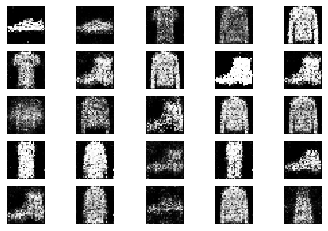

2801 [D loss: 0.639399, acc.: 57.81%] [G loss: 0.969974]
2802 [D loss: 0.679673, acc.: 60.94%] [G loss: 0.960656]
2803 [D loss: 0.678220, acc.: 50.00%] [G loss: 0.947119]
2804 [D loss: 0.600115, acc.: 73.44%] [G loss: 0.941766]
2805 [D loss: 0.608745, acc.: 65.62%] [G loss: 0.992889]
2806 [D loss: 0.618104, acc.: 64.06%] [G loss: 0.917709]
2807 [D loss: 0.642837, acc.: 62.50%] [G loss: 0.800128]
2808 [D loss: 0.604175, acc.: 67.19%] [G loss: 0.846896]
2809 [D loss: 0.580077, acc.: 71.88%] [G loss: 0.918975]
2810 [D loss: 0.680200, acc.: 51.56%] [G loss: 0.872235]
2811 [D loss: 0.641151, acc.: 53.12%] [G loss: 0.894908]
2812 [D loss: 0.630973, acc.: 62.50%] [G loss: 0.946207]
2813 [D loss: 0.708968, acc.: 51.56%] [G loss: 0.872923]
2814 [D loss: 0.611636, acc.: 70.31%] [G loss: 0.917359]
2815 [D loss: 0.666848, acc.: 59.38%] [G loss: 0.965697]
2816 [D loss: 0.644793, acc.: 60.94%] [G loss: 0.891031]
2817 [D loss: 0.585024, acc.: 64.06%] [G loss: 0.967872]
2818 [D loss: 0.591149, acc.: 7

2947 [D loss: 0.593603, acc.: 70.31%] [G loss: 1.085275]
2948 [D loss: 0.637007, acc.: 67.19%] [G loss: 0.964313]
2949 [D loss: 0.593008, acc.: 68.75%] [G loss: 0.975653]
2950 [D loss: 0.637235, acc.: 65.62%] [G loss: 0.936304]
2951 [D loss: 0.614210, acc.: 67.19%] [G loss: 0.914854]
2952 [D loss: 0.627095, acc.: 60.94%] [G loss: 0.824130]
2953 [D loss: 0.664351, acc.: 64.06%] [G loss: 0.837176]
2954 [D loss: 0.598415, acc.: 70.31%] [G loss: 0.906934]
2955 [D loss: 0.613841, acc.: 71.88%] [G loss: 0.834692]
2956 [D loss: 0.626368, acc.: 57.81%] [G loss: 0.906346]
2957 [D loss: 0.650973, acc.: 57.81%] [G loss: 0.818467]
2958 [D loss: 0.712350, acc.: 51.56%] [G loss: 0.843153]
2959 [D loss: 0.608048, acc.: 65.62%] [G loss: 0.860702]
2960 [D loss: 0.770744, acc.: 45.31%] [G loss: 0.864260]
2961 [D loss: 0.585091, acc.: 65.62%] [G loss: 0.935710]
2962 [D loss: 0.642427, acc.: 59.38%] [G loss: 0.924695]
2963 [D loss: 0.650540, acc.: 57.81%] [G loss: 0.929618]
2964 [D loss: 0.610867, acc.: 6

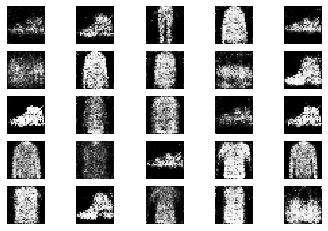

In [4]:

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3001, batch_size=32, sample_interval=200)

### Added an extra epoch in order to get the last images